In [1]:
# Import SQLAlchemy and other dependencies 
# Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [2]:
# Create engine using the `hawaii.sqlite` database file created in database_engineering steps

engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`

Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base

Base.classes.keys()

['measurements', 'station']

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurements', 'station']

In [7]:
# Use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurements LIMIT 10').fetchall()

[]

In [8]:
# Reflect Database into ORM class
Station = Base.classes.station
Measurements = Base.classes.measurements

In [9]:
# Start a session to query the database
session = Session(engine)

Precipitation Analysis

In [10]:
# Grab the last date entry in the data table
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

None


In [11]:
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# query to pull the last year of precipitation data
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [13]:
# Load the data from the query into a dataframe

rain_df = pd.DataFrame(rain)
rain_df.head()

""


In [17]:
# reset the index to the date

rain_df.set_index('date').head()

KeyError: 'date'

In [19]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'date'

In [20]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

ValueError: Cannot describe a DataFrame without columns

Station Analysis

In [21]:
# Count the number of stations in the Measurement table
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 0 stations.


In [22]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

IndexError: list index out of range

In [23]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

NameError: name 'busiest' is not defined

In [24]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

NameError: name 'temperature' is not defined

Temperature Analysis

In [25]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)

[(None, None, None)]


In [26]:
# calculate the min/max/avg from last year that matches the trip date
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(None, None, None)]


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

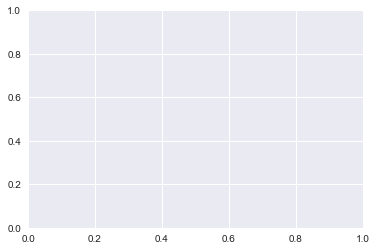

In [27]:
# plotting the data as a boxplot

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

In [28]:
# plot calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

Optional (Recommended) Analysis

In [29]:
# set the trip variables of arrive and leave for prior year
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)

2017-04-01
2017-04-15


In [30]:
# query to pull the rain fall from last year matching this years trip
vacation_data = session.query(Measurements.station, Measurements.date, Measurements.prcp, Measurements.tobs).\
    filter(Measurements.date >= lst_year_arrive).\
    filter(Measurements.date <= lst_year_leave).\
    order_by(Measurements.station).all()

In [31]:
# load the query results into a dataframe and pivot on station
vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

KeyError: 'prcp'